In [14]:
# 安装包
# !pip install scikit-plot
# import scikitplot.plotters as skplt

# !pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer, util


In [15]:
# import scikitplot as skplt
# from sentence_transformers import SentenceTransformer, util

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation

from pprint import pprint;
import pickle

import warnings

warnings.filterwarnings("ignore")

import pandas as pd

pd.set_option('display.max_colwidth', None)

import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

print("\n\n 库已加载！")




 库已加载！


In [16]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

## 加载数据并切分数据集

In [17]:
with open(r"D:\GraduationDesign\sms-spam-detector\data\spam_dic.pkl", "rb") as f:
    spam_vecs = pickle.load(f)
with open(r"D:\GraduationDesign\sms-spam-detector\data\spam_label.pkl", "rb") as f:
    spam_labels = pickle.load(f)

### 定义分类器

In [18]:
classifiers = [
    GaussianNB(),
    SVC(),
    LinearSVC(),
    LogisticRegression(),
    SGDClassifier(),
    KNeighborsClassifier(),
    MLPClassifier(),
]
print("分类器模型已加载!")

分类器模型已加载!


In [19]:
# 拟合分类器并返回指标
def train_test_clf(clf, X_train, y_train, X_test, y_test, tag="", isShow=False):
    """
    Args:
        clf:     分类器对象
        X_train: 训练数据编码值
        y_train: 训练数据标签
        X_test:  测试数据编码值
        y_test:  测试数据标签
        tag: 字符串（编码器和分类器）
        isShow: 是否画图
    """
    # 拟合分类器
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 计算分类器评估值
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

    # 打印评估值
    print('{:<36s} Balanced accuracy: {:.2f}%'.format(tag, bacc * 100))
    if isShow:
        plot_confusion_matrix(clf, X_test, y_test)
        plot_roc_curve(clf, X_test, y_test)
    return acc, bacc, prec, recall, f1


print("训练函数已加载!")

训练函数已加载!


In [20]:
# 8：2划分数据集为训练集和测试集
def split_dataset(X, y, n_data=100, isShow=False):
    X_train, X_test, y_train, y_test = train_test_split(X[:n_data],
                                                        y[:n_data],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=0)  # random_state=0每次分割得到不同的数组，1每次得到相同的数组
    # 打印数据比例
    if isShow:
        _, ax = plt.subplots(1, 2)
        y_train.value_counts().plot(ax=ax[0], kind='pie', figsize=(8, 8),
                                    autopct=lambda x: "%d" % round(y_train.shape[0] * x / 100),
                                    ylabel='', title='Train dataset')
        y_test.value_counts().plot(ax=ax[1], kind='pie', figsize=(8, 8),
                                   autopct=lambda x: "%d" % round(y_test.shape[0] * x / 100),
                                   ylabel='', title='Test dataset')
        plt.show()

    return X_train, X_test, y_train, y_test


print("分割函数已加载!")

分割函数已加载!


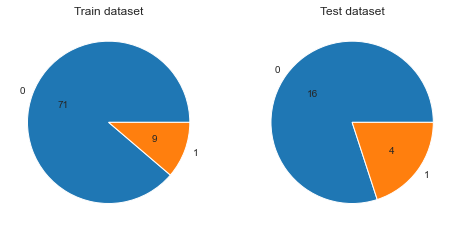

In [21]:
# 尝试分割（默认100数据）
split_dataset(spam_vecs['BoW'], spam_labels, isShow=True);

处理数据的数量:  4869


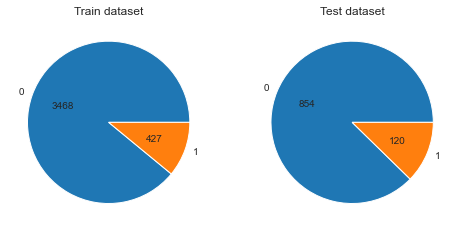

[BoW GaussianNB]                     Balanced accuracy: 77.20%
[BoW SVC]                            Balanced accuracy: 86.55%
[BoW LinearSVC]                      Balanced accuracy: 93.11%
[BoW LogisticRegression]             Balanced accuracy: 89.71%
[BoW SGDClassifier]                  Balanced accuracy: 90.36%
[BoW KNeighborsClassifier]           Balanced accuracy: 71.67%
[BoW MLPClassifier]                  Balanced accuracy: 93.11%


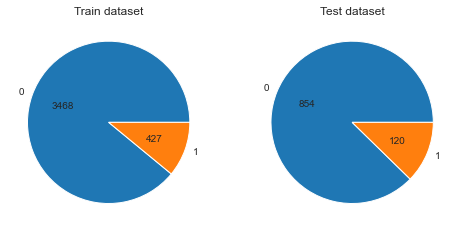

[TFIDF GaussianNB]                   Balanced accuracy: 79.31%
[TFIDF SVC]                          Balanced accuracy: 88.40%
[TFIDF LinearSVC]                    Balanced accuracy: 92.21%
[TFIDF LogisticRegression]           Balanced accuracy: 83.57%
[TFIDF SGDClassifier]                Balanced accuracy: 90.01%
[TFIDF KNeighborsClassifier]         Balanced accuracy: 73.22%
[TFIDF MLPClassifier]                Balanced accuracy: 92.99%


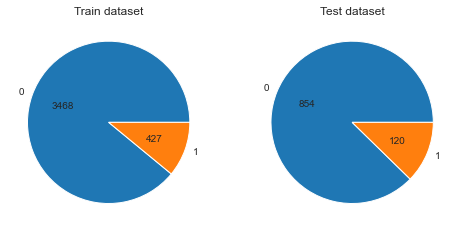

[BERT GaussianNB]                    Balanced accuracy: 96.91%
[BERT SVC]                           Balanced accuracy: 96.19%
[BERT LinearSVC]                     Balanced accuracy: 96.13%
[BERT LogisticRegression]            Balanced accuracy: 94.11%
[BERT SGDClassifier]                 Balanced accuracy: 95.72%
[BERT KNeighborsClassifier]          Balanced accuracy: 96.49%
[BERT MLPClassifier]                 Balanced accuracy: 96.13%
完成!


In [22]:
import re

# N_data = 1000
N_data = len(spam_labels)
print("处理数据的数量: ", N_data)

np.random.seed(seed=20222022)  # Seed确保可复现

results = pd.DataFrame(columns=['Encoder', 'Classifier', 'Acc', 'BAcc', 'Prec', 'Recall', 'F1'])
# results_test = pd.DataFrame(columns=['Epoch', 'Encoder', 'Classifier', 'Acc', 'BAcc', 'Prec', 'Recall', 'F1'])


# 每个编码器在每个分类器的表现
for key in spam_vecs.keys():
    # 8：2划分训练集和测试集
    X_train, X_test, y_train, y_test = split_dataset(spam_vecs[key], spam_labels, N_data, isShow=True)
    for clf in classifiers:
        # 拟合分类器并获取评分
        acc, bacc, prec, recall, f1 = train_test_clf(clf, X_train, y_train, X_test, y_test,
                                                     "[%s %s] " % (key, type(clf).__name__), isShow=False)
        # 记录评估指标
        results = results.append({'Encoder': key,
                                  'Classifier': type(clf).__name__,
                                  'Acc': acc,
                                  'BAcc': bacc,
                                  'Prec': prec,
                                  'Recall': recall,
                                  'F1': f1}, ignore_index=True)
# # 打印评估指标
# pprint(results)
print("完成!")

In [23]:
# 打印评估指标
pprint(results)

   Encoder            Classifier   Acc  BAcc   Prec  Recall    F1
0      BoW            GaussianNB 67.6% 77.2%  26.2%   90.0% 40.6%
1      BoW                   SVC 96.5% 86.5%  97.8%   73.3% 83.8%
2      BoW             LinearSVC 97.3% 93.1%  90.5%   87.5% 89.0%
3      BoW    LogisticRegression 97.0% 89.7%  95.0%   80.0% 86.9%
4      BoW         SGDClassifier 96.9% 90.4%  92.5%   81.7% 86.7%
5      BoW  KNeighborsClassifier 93.0% 71.7% 100.0%   43.3% 60.5%
6      BoW         MLPClassifier 97.3% 93.1%  90.5%   87.5% 89.0%
7    TFIDF            GaussianNB 71.3% 79.3%  28.7%   90.0% 43.5%
8    TFIDF                   SVC 96.6% 88.4%  93.9%   77.5% 84.9%
9    TFIDF             LinearSVC 97.0% 92.2%  89.6%   85.8% 87.7%
10   TFIDF    LogisticRegression 95.7% 83.6%  96.4%   67.5% 79.4%
11   TFIDF         SGDClassifier 96.9% 90.0%  93.3%   80.8% 86.6%
12   TFIDF  KNeighborsClassifier 93.2% 73.2%  96.6%   46.7% 62.9%
13   TFIDF         MLPClassifier 97.1% 93.0%  89.0%   87.5% 88.2%
14    BERT

In [24]:
# 保存评估值结果
with open('D:\GraduationDesign\sms-spam-detector\data\clf_results.pkl', "wb") as f1:
    pickle.dump(results, f1)

In [25]:
# 加载结果
results = pickle.load(open(r'D:\GraduationDesign\sms-spam-detector\data\clf_results.pkl', "rb"))

In [27]:
results

,Encoder,Classifier,Acc,BAcc,Prec,Recall,F1
0,BoW,GaussianNB,67.6%,77.2%,26.2%,90.0%,40.6%
1,BoW,SVC,96.5%,86.5%,97.8%,73.3%,83.8%
2,BoW,LinearSVC,97.3%,93.1%,90.5%,87.5%,89.0%
3,BoW,LogisticRegression,97.0%,89.7%,95.0%,80.0%,86.9%
4,BoW,SGDClassifier,96.9%,90.4%,92.5%,81.7%,86.7%
5,BoW,KNeighborsClassifier,93.0%,71.7%,100.0%,43.3%,60.5%
6,BoW,MLPClassifier,97.3%,93.1%,90.5%,87.5%,89.0%
7,TFIDF,GaussianNB,71.3%,79.3%,28.7%,90.0%,43.5%
8,TFIDF,SVC,96.6%,88.4%,93.9%,77.5%,84.9%
9,TFIDF,LinearSVC,97.0%,92.2%,89.6%,85.8%,87.7%


In [26]:
pd.options.display.float_format = '{:,.1%}'.format
pd.options.display.max_rows = None

print("\n\n>>>>>编码器与分类器组合实验: ", results.shape)

# 打印统计数据
display(results.groupby(['Encoder']).describe())

aggregations = {
    'BAcc': [lambda x: "%.2f%%" % (np.mean(x) * 100)],  # 平均值+-标准差
    'Acc': [lambda x: "%.2f%%" % (np.mean(x) * 100)],
    'Recall': [lambda x: "%.2f%%" % (np.mean(x) * 100)],
    'Prec': [lambda x: "%.2f%%" % (np.mean(x) * 100)],
    'F1': [lambda x: "%.2f%%" % (np.mean(x) * 100)],
}

# 打印聚合的统计数据
display(results.groupby(['Encoder', 'Classifier']).agg(aggregations))



>>>>>编码器与分类器组合实验:  (21, 7)


Acc                                             BAcc        ...  \
         count  mean   std   min   25%   50%   75%   max  count  mean  ...   
Encoder                                                                ...   
BERT    700.0% 98.8%  0.2% 98.5% 98.8% 98.9% 98.9% 99.0% 700.0% 96.0%  ...   
BoW     700.0% 92.2% 11.0% 67.6% 94.8% 96.9% 97.2% 97.3% 700.0% 86.0%  ...   
TFIDF   700.0% 92.5%  9.5% 71.3% 94.5% 96.6% 97.0% 97.1% 700.0% 85.7%  ...   

        Recall           F1                                            
           75%   max  count  mean   std   min   25%   50%   75%   max  
Encoder                                                                
BERT     92.9% 94.2% 700.0% 95.1%  0.8% 93.4% 95.1% 95.3% 95.5% 95.8%  
BoW      87.5% 90.0% 700.0% 76.6% 18.8% 40.6% 72.1% 86.7% 87.9% 89.0%  
TFIDF    86.7% 90.0% 700.0% 76.2% 16.9% 43.5% 71.2% 84.9% 87.1% 88.2%  

[3 rows x 40 columns]

BAcc      Acc   Recall     Prec       F1
                             <lambda> <lambda> <lambda> <lambda> <lambda>
Encoder Classifier                                                       
BERT    GaussianNB             96.91%   98.97%   94.17%   97.41%   95.76%
        KNeighborsClassifier   96.49%   98.87%   93.33%   97.39%   95.32%
        LinearSVC              96.13%   98.87%   92.50%   98.23%   95.28%
        LogisticRegression     94.11%   98.46%   88.33%   99.07%   93.39%
        MLPClassifier          96.13%   98.87%   92.50%   98.23%   95.28%
        SGDClassifier          95.72%   98.77%   91.67%   98.21%   94.83%
        SVC                    96.19%   98.97%   92.50%   99.11%   95.69%
BoW     GaussianNB             77.20%   67.56%   90.00%   26.21%   40.60%
        KNeighborsClassifier   71.67%   93.02%   43.33%  100.00%   60.47%
        LinearSVC              93.11%   97.33%   87.50%   90.52%   88.98%
        LogisticRegression     89.71%   97.02%   80.00%   95.05%   86.88%
        MLPClassifier          93.11%   97.33%   87.50%   90.52%   88.98%
        SGDClassifier          90.36%   96.92%   81.67%   92.45%   86.73%
        SVC                    86.55%   96.51%   73.33%   97.78%   83.81%
TFIDF   GaussianNB             79.31%   71.25%   90.00%   28.72%   43.55%
        KNeighborsClassifier   73.22%   93.22%   46.67%   96.55%   62.92%
        LinearSVC              92.21%   97.02%   85.83%   89.57%   87.66%
        LogisticRegression     83.57%   95.69%   67.50%   96.43%   79.41%
        MLPClassifier          92.99%   97.13%   87.50%   88.98%   88.24%
        SGDClassifier          90.01%   96.92%   80.83%   93.27%   86.61%
        SVC                    88.40%   96.61%   77.50%   93.94%   84.93%